In [3253]:
# Standard Packages
import pandas as pd
import numpy as np

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Scipy Stats
import scipy.stats as stats 
from scipy.stats import pearsonr

# Statsmodel Api
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor


# SKLearn Modules
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

#Add Extra Modules
from math import sin, cos, sqrt, atan2
from datetime import datetime, timedelta
import cpi
import re



# Suppress future and deprecation warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.options.display.max_columns = None
pd.options.display.width = None

In [3254]:
data = pd.read_csv("data/kc_house_data.csv")
df_school = pd.read_csv('data/AIM-EOC-MSP-SBA_Assessments_School__with_suppression_-_new_format__2017.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [3255]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates the Haversine distance between two points on the Earth's surface.
    """
    R = 6371  # radius of Earth in km

    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d

# GPS location (Seattle city center)
city_lat = 47.6062
city_long = -122.3321

data["distance"] = haversine(city_lat, city_long, data["lat"], data["long"])

In [3256]:
# Define a dictionary with the district information
district_dict = {
    17001: ['Seattle', 47.604224, -122.310822],
    17210: ['Federal Way', 47.306740, -122.334571],
    17216: ['Enumclaw', 47.202359, -121.989672],
    17400: ['Mercer Island', 47.563806, -122.221739],
    17401: ['Highline', 47.503040, -122.333787],
    17402: ['Vashon Island', 47.415653, -122.465464],
    17403: ['Renton', 47.480680, -122.194300],
    17404: ['Skykomish', 47.709979, -121.358584],
    17405: ['Bellevue', 47.601939, -122.153399],
    17406: ['Tukwila', 47.465515, -122.264383],
    17408: ['Auburn', 47.298994, -122.209005],
    17409: ['Tahoma', 47.408238, -121.978171],
    17410: ['Snoqualmie Valley', 47.467175, -121.721867],
    17411: ['Issaquah', 47.541392, -122.042553],
    17412: ['Shoreline', 47.758887, -122.340132],
    17414: ['Lake Washington', 47.682244, -122.116046],
    17415: ['Kent', 47.370687, -122.179470],
    17417: ['Northshore', 47.768389, -122.152624],
    27417: ['Fife', 47.246443, -122.331492],
    17407: ['Riverview', 47.706997, -121.847689]
}

# Create a dataframe from the dictionary
df_school_district = pd.DataFrame.from_dict(district_dict, orient='index', columns=['district', 'lat', 'long'])
df_school_district.reset_index(inplace=True)
df_school_district.rename(columns={'index': 'DistrictCode'}, inplace=True)

In [3257]:
df_school.dropna(subset=['countLevel4'], inplace=True)
grouped = df_school.groupby("DistrictCode")["PercentMetStandardIncludingPP"].mean()
grouped = grouped.reset_index()
df_school_district = df_school_district.merge(grouped, on="DistrictCode")
df_school_district = df_school_district.rename(columns={"PercentMetStandardIncludingPP": "average_grade"})

# Print the dataframe
df_school_district

,DistrictCode,district,lat,long,average_grade
0,17001,Seattle,47.60,-122.31,58.66
1,17210,Federal Way,47.31,-122.33,41.28
2,17216,Enumclaw,47.20,-121.99,58.12
3,17400,Mercer Island,47.56,-122.22,80.49
4,17401,Highline,47.50,-122.33,41.93
5,17402,Vashon Island,47.42,-122.47,43.45
6,17403,Renton,47.48,-122.19,49.05
7,17405,Bellevue,47.60,-122.15,67.68
8,17406,Tukwila,47.47,-122.26,38.71
9,17408,Auburn,47.30,-122.21,53.26


In [3258]:
# Calculate haversine distances between all the points in the data DataFrame and the df_school_district DataFrame
distances = df_school_district.apply(lambda x: np.sqrt((data['lat'] - x['lat'])**2 + (data['long'] - x['long'])**2), axis=1)

# Find the index of the minimum value in each row
min_idx = distances.idxmin(axis=0)

# Look up the corresponding average_grade value in the df_school_district DataFrame
data = data.assign(school_grade=df_school_district.loc[min_idx, 'average_grade'].values)


Text(0.5, 1.0, "'Boxplot 'Waterfront' vs 'Price'")

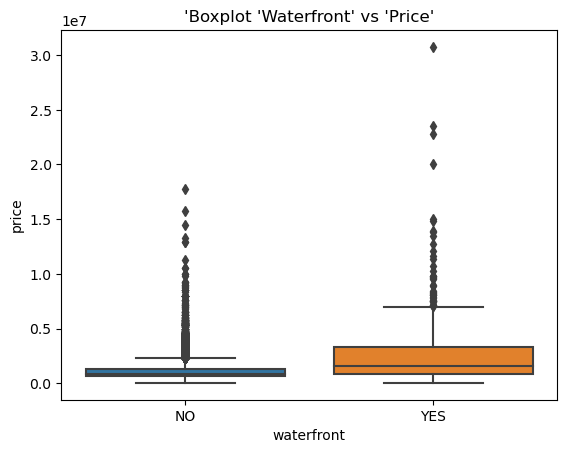

In [3259]:
data['waterfront'] = data['waterfront'].astype('category')
sns.boxplot(x='waterfront', y='price', data=data)
plt.title("'Boxplot 'Waterfront' vs 'Price'")

In [3260]:
X = data[['distance']]
Y = data['price']
lm = LinearRegression()
lm.fit(X,Y)
lm.score(X, Y)

0.0008122584932279686

In [3261]:
data = data[data['sqft_living'] <= 5000]
data = data[data['sqft_living'] >= 100]
data = data[data['distance'] <= 50]
data = data[data['price'] <= 2500000]
#data = data[data['price'] >= 100000]

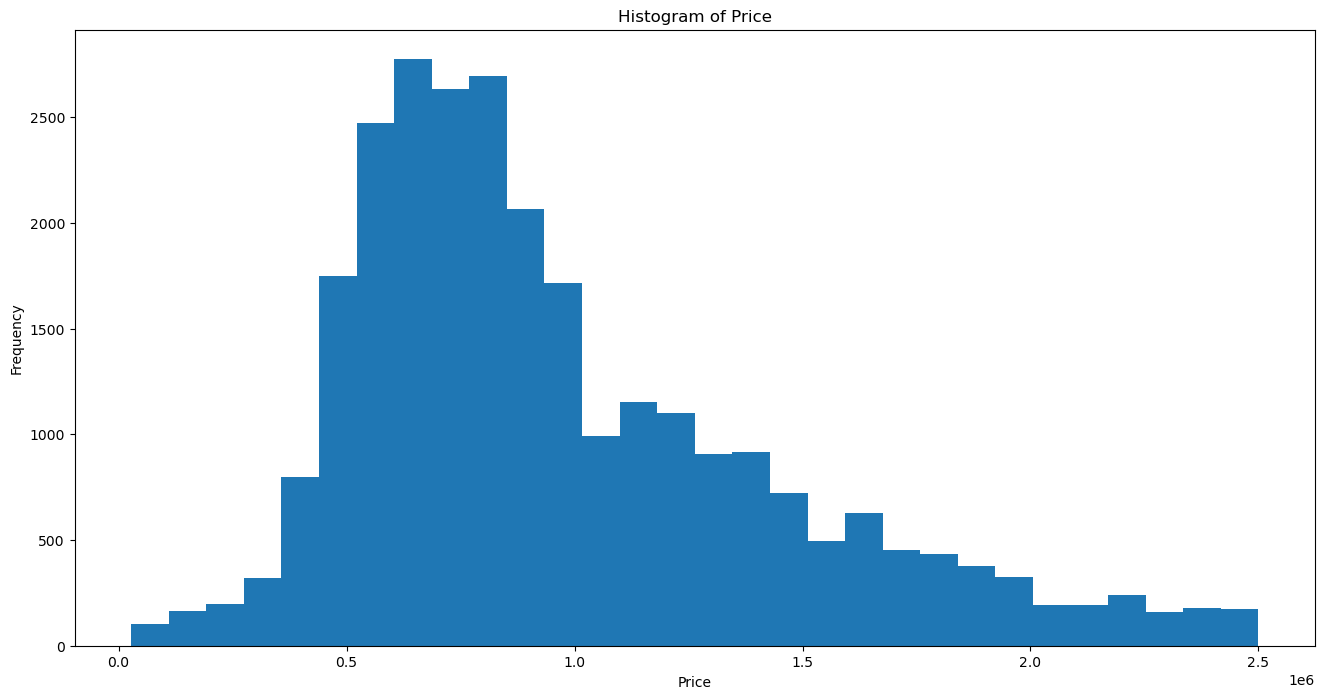

In [3262]:
plt.figure(figsize=(16,8))
plt.hist(data['price'], bins=30)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price')
plt.show()

In [3263]:
data.loc[21804]

id                                                       923059205
date                                                      8/3/2021
price                                                    662000.00
bedrooms                                                         1
bathrooms                                                     1.00
sqft_living                                                    370
sqft_lot                                                     28160
floors                                                        1.00
waterfront                                                      NO
greenbelt                                                       NO
nuisance                                                       YES
view                                                          NONE
condition                                                     Fair
grade                                                       3 Poor
heat_source                                                   

Text(0.5, 1.0, "'Boxplot 'sqft_living' vs 'Price'")

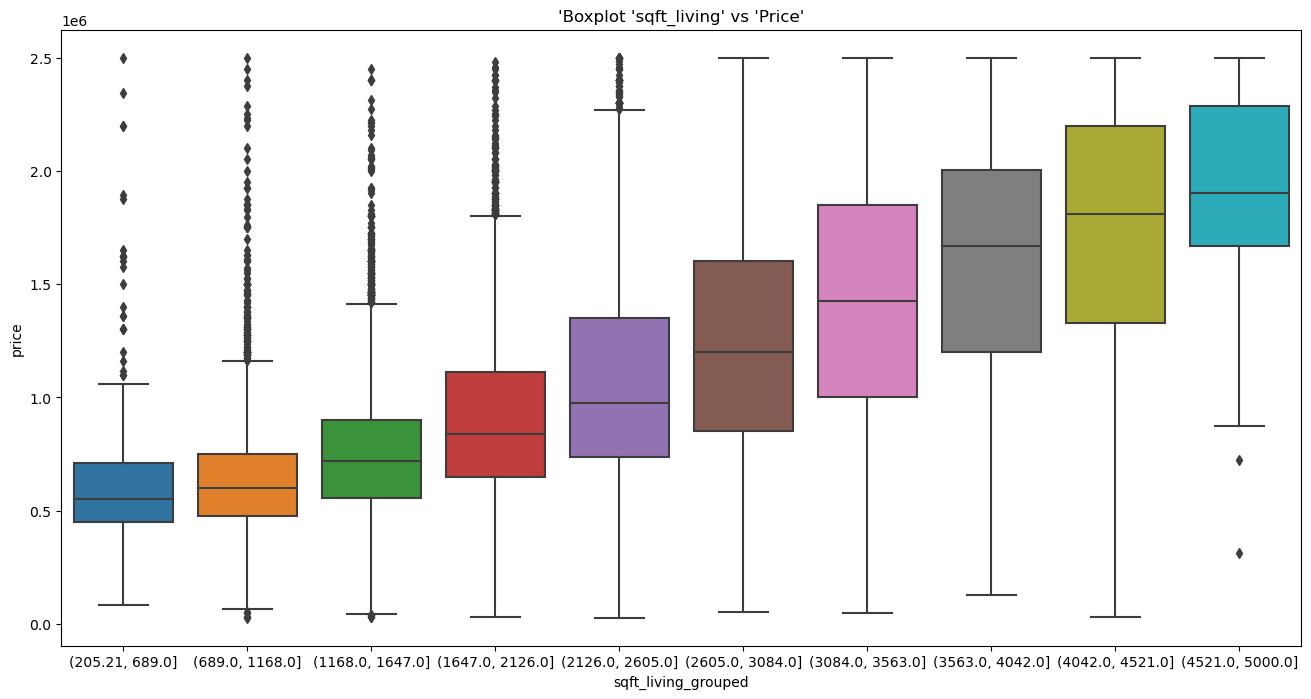

In [3264]:
plt.figure(figsize=(16,8))
data['sqft_living_grouped'] = pd.cut(data['sqft_living'], bins=10)
sns.boxplot(x='sqft_living_grouped', y='price', data=data)
plt.title("'Boxplot 'sqft_living' vs 'Price'")

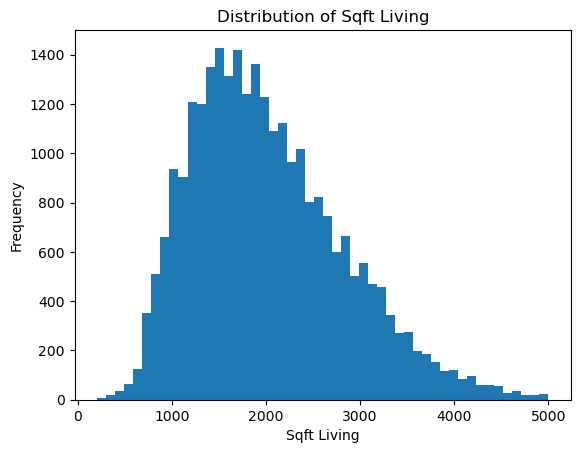

In [3265]:
plt.hist(data['sqft_living'], bins=50)
plt.title("Distribution of Sqft Living")
plt.xlabel("Sqft Living")
plt.ylabel("Frequency")
plt.show()

In [3266]:
data = data.dropna()
data['waterfront'] = data['waterfront'].apply(lambda x: 1 if x == 'YES' else 0)
data['greenbelt'] = data['greenbelt'].apply(lambda x: 1 if x == 'YES' else 0)
data['nuisance'] = data['nuisance'].apply(lambda x: 1 if x == 'YES' else 0)

In [3267]:
data['grade'] = data['grade'].str.extract(r'(\d+)').astype(int)
data['grade'].unique()

array([ 7,  9,  8,  6, 10,  5,  4, 11,  3, 12,  2])

In [3268]:
condition_mapping = {'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1}
data['condition'] = data['condition'].map(condition_mapping)
data['condition'].unique()

array([4, 3, 5, 2, 1], dtype=int64)

In [3269]:
view_mapping = {'NONE': 1, 'FAIR': 2, 'AVERAGE': 3, 'GOOD': 4, 'EXCELLENT': 5}
data['view'] = data['view'].map(view_mapping)
data['view'].unique()

array([1, 3, 5, 2, 4], dtype=int64)

In [3270]:
data = data.drop(['heat_source'], axis=1)
data = data.drop(['sqft_living_grouped'], axis=1)

In [3271]:
data['date'] = pd.to_datetime(data['date'])
data = data[data['date'] < '2022-01-01']
data['price'] = data.apply(lambda row: cpi.inflate(row['price'],row['date'].year), axis=1)

In [3272]:
def extract_zipcode(address):
    zipcode = re.findall(r'\b\d{5}\b', address)
    if len(zipcode) > 0:
        return zipcode[0]
    else:
        return ''

data['zip_code'] = data['address'].apply(extract_zipcode)

In [3273]:
# First, calculate the mean price for each zip code
zip_code_prices = data.groupby('zip_code')['sqft_living'].mean()

# Next, divide the zip codes into price categories based on their mean prices
zip_code_categories = pd.cut(zip_code_prices, bins=5, labels=False, retbins=False)

# Finally, add the price category as a new column to the train_data dataframe
data['zip_code_category'] = data['zip_code'].map(zip_code_categories)

data.drop(['zip_code'], axis=1, inplace=True)
data['has_basement'] = (data['sqft_basement'] > 0).astype(int)
data['has_patio'] = (data['sqft_patio'] > 0).astype(int)
data['sqft_garage'] = (data['sqft_garage'] > 0).astype(int)


In [3274]:
# Log transform the columns 'price', 'sqft_living', and 'sqft_lot'
data[['sqft_living', 'sqft_lot']] = np.log(data[['sqft_living', 'sqft_lot']])

# Normalize the columns 'price_log', 'sqft_living_log', and 'sqft_lot_log'
data[['sqft_living', 'sqft_lot']] = (data[['sqft_living', 'sqft_lot']] - data[['sqft_living', 'sqft_lot']].mean()) / data[['sqft_living', 'sqft_lot']].std()

In [3275]:
train_data, test_data, train_labels, test_labels = train_test_split(data.drop(columns=["id", "address", "lat", "long","sewer_system",'sqft_above','sqft_basement','sqft_patio','sqft_garage']), data["price"], test_size=0.2, random_state=41)

In [3276]:
train_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,yr_built,yr_renovated,distance,school_grade,zip_code_category,has_basement,has_patio
21659,2021-07-01,500000.00,3,2.50,-0.54,-0.67,2.00,0,0,0,1,3,7,2000,0,33.06,67.24,1,0,0
8949,2021-10-26,560000.00,3,2.00,-0.49,0.61,1.00,0,0,0,1,3,8,1978,0,27.94,51.69,2,1,0
30036,2021-08-14,1900000.00,6,4.50,2.02,0.47,2.00,0,0,1,5,3,8,1961,0,7.19,58.66,1,1,1
12511,2021-09-15,570000.00,3,2.50,-0.24,-0.37,2.00,0,0,0,1,4,7,1991,0,30.78,51.69,1,0,0
17882,2021-06-30,715000.00,3,1.50,-2.12,-1.99,2.00,0,0,0,1,3,8,2003,0,5.66,58.66,1,1,0


In [3277]:

train_data['yr_renovated'] = np.where(train_data['yr_renovated'] == 0, train_data['yr_built'], train_data['yr_renovated'])
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['year'] = train_data['date'].dt.year
train_data['years_since_build_or_renov'] = train_data['year'] - train_data[['yr_built', 'yr_renovated']].min(axis=1)
train_data.drop(['date', 'year', 'yr_built', 'yr_renovated','sqft_lot'], axis=1, inplace=True)

test_data['yr_renovated'] = np.where(test_data['yr_renovated'] == 0, test_data['yr_built'], test_data['yr_renovated'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['year'] = test_data['date'].dt.year
test_data['years_since_build_or_renov'] = test_data['year'] - test_data[['yr_built', 'yr_renovated']].min(axis=1)
test_data.drop(['date', 'year', 'yr_built', 'yr_renovated','sqft_lot'], axis=1, inplace=True)


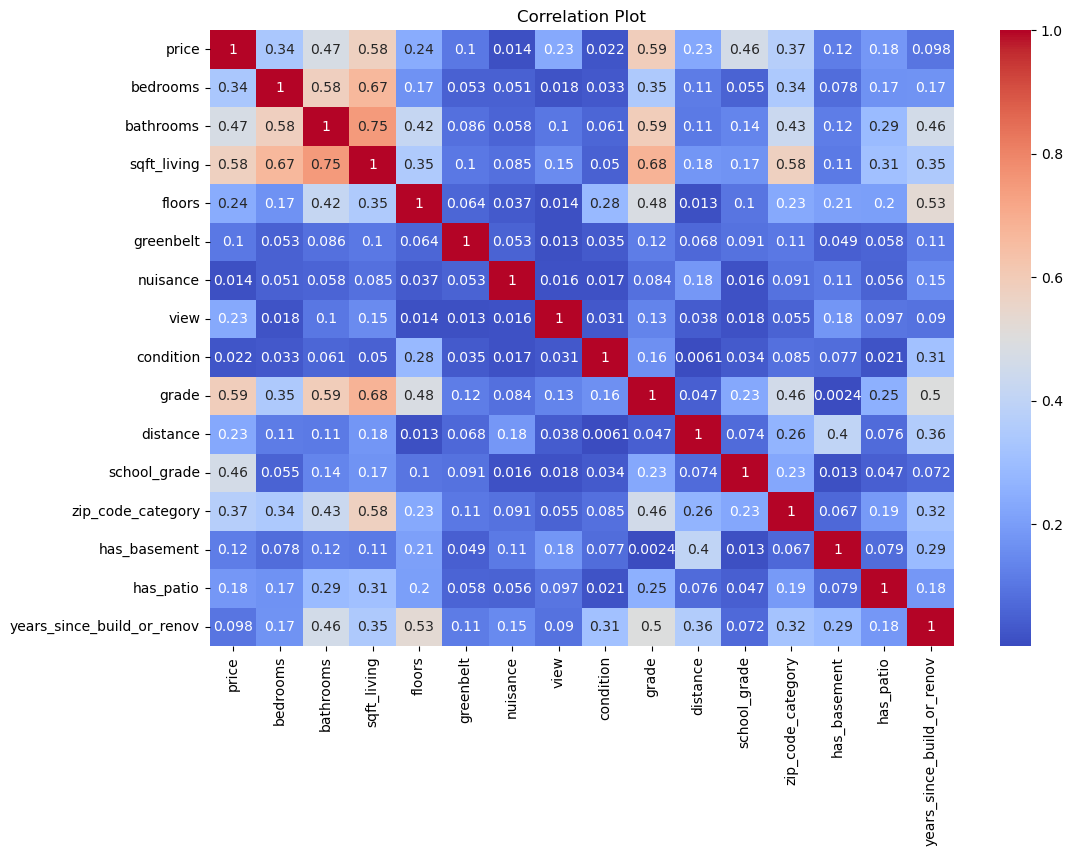

In [3278]:
# Calculate the correlation matrix
corr = abs(train_data.corr())

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation Plot")

# Show the plot
plt.show()

In [3279]:
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     1585.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:05:56   Log-Likelihood:            -1.9554e+05
No. Observations:               14030   AIC:                         3.911e+05
Df Residuals:                   14013   BIC:                         3.912e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [3280]:
train_data.drop(['bathrooms'], axis=1, inplace=True)

test_data.drop(['bathrooms'], axis=1, inplace=True)

In [3281]:
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     1661.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:05:57   Log-Likelihood:            -1.9562e+05
No. Observations:               14030   AIC:                         3.913e+05
Df Residuals:                   14014   BIC:                         3.914e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [3282]:
vif = [variance_inflation_factor(train_data.values, i) for i in range(train_data.shape[1])]
vif_df = pd.DataFrame({'Features': train_data.columns, 'VIF': vif})
vif_df.sort_values('VIF', ascending=False)

,Features,VIF
9,grade,73.40
11,school_grade,32.68
8,condition,26.77
1,bedrooms,21.81
3,floors,14.26
0,price,14.09
12,zip_code_category,8.60
10,distance,7.41
15,years_since_build_or_renov,5.86
14,has_patio,4.98


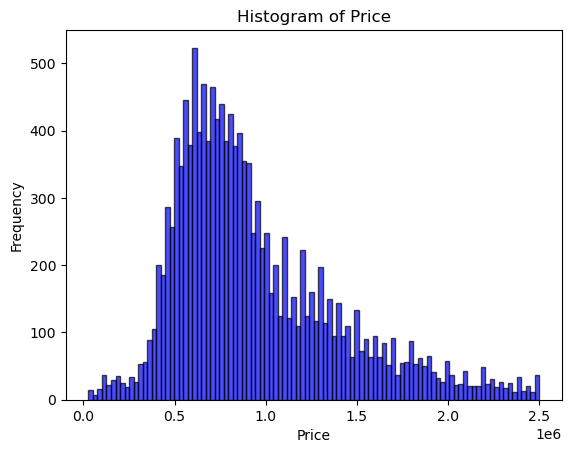

In [3283]:
plt.hist(train_data['price'], bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price')
plt.show()


In [3284]:
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     1661.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:05:57   Log-Likelihood:            -1.9562e+05
No. Observations:               14030   AIC:                         3.913e+05
Df Residuals:                   14014   BIC:                         3.914e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

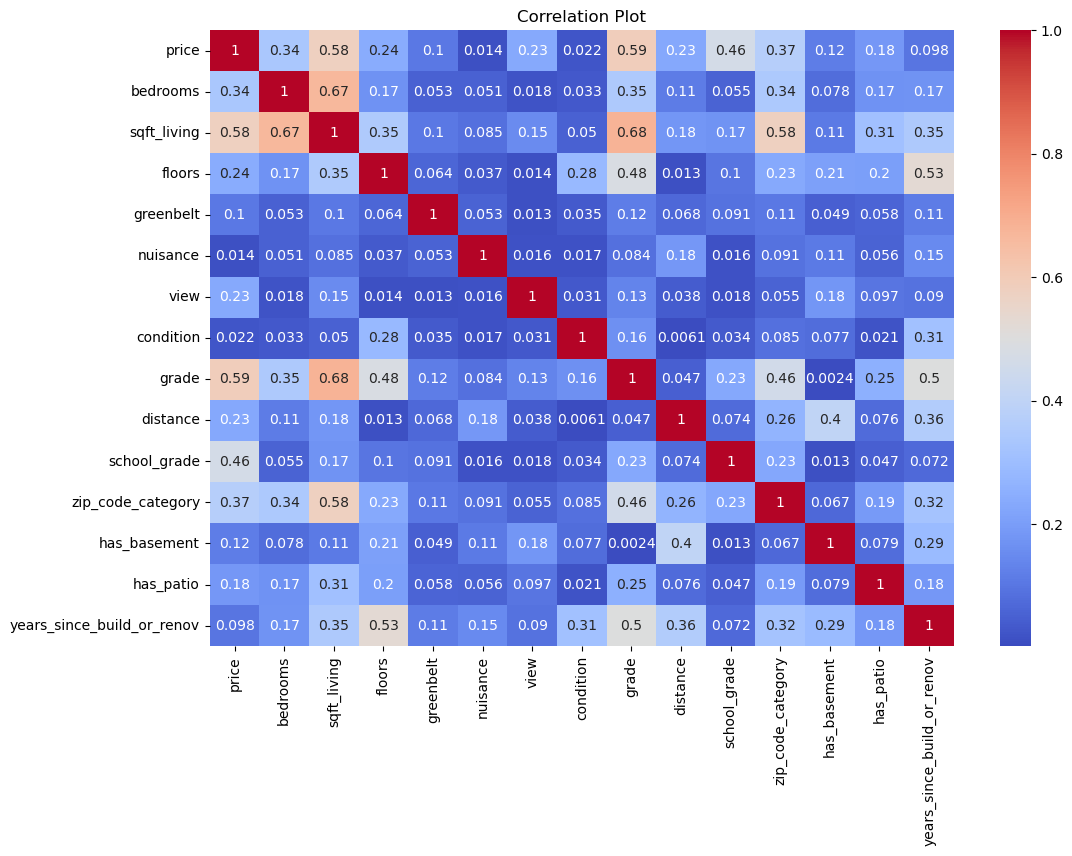

In [3285]:
# Calculate the correlation matrix
corr = abs(train_data.corr())

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation Plot")

# Show the plot
plt.show()

In [3286]:
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     1661.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:05:58   Log-Likelihood:            -1.9562e+05
No. Observations:               14030   AIC:                         3.913e+05
Df Residuals:                   14014   BIC:                         3.914e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [3287]:
train_data.drop(["has_patio"], axis=1, inplace=True)
test_data.drop(["has_patio"], axis=1, inplace=True)

train_data.drop(["floors"], axis=1, inplace=True)
test_data.drop(["floors"], axis=1, inplace=True)

train_data.drop(["nuisance"], axis=1, inplace=True)
test_data.drop(["nuisance"], axis=1, inplace=True)

train_data.drop(["greenbelt"], axis=1, inplace=True)
test_data.drop(["greenbelt"], axis=1, inplace=True)

train_data.drop(["condition"], axis=1, inplace=True)
test_data.drop(["condition"], axis=1, inplace=True)

train_data.drop(["sqft_living"], axis=1, inplace=True)
test_data.drop(["sqft_living"], axis=1, inplace=True)

                   

In [3288]:
train_data[['distance', 'years_since_build_or_renov', 'school_grade']] = (train_data[['distance', 'years_since_build_or_renov', 'school_grade']] - train_data[['distance', 'years_since_build_or_renov', 'school_grade']].mean()) / train_data[[ 'distance', 'years_since_build_or_renov', 'school_grade']].std()

test_data[['distance', 'years_since_build_or_renov', 'school_grade']] = (test_data[['distance', 'years_since_build_or_renov', 'school_grade']] - test_data[['distance', 'years_since_build_or_renov', 'school_grade']].mean()) / test_data[[ 'distance', 'years_since_build_or_renov', 'school_grade']].std()

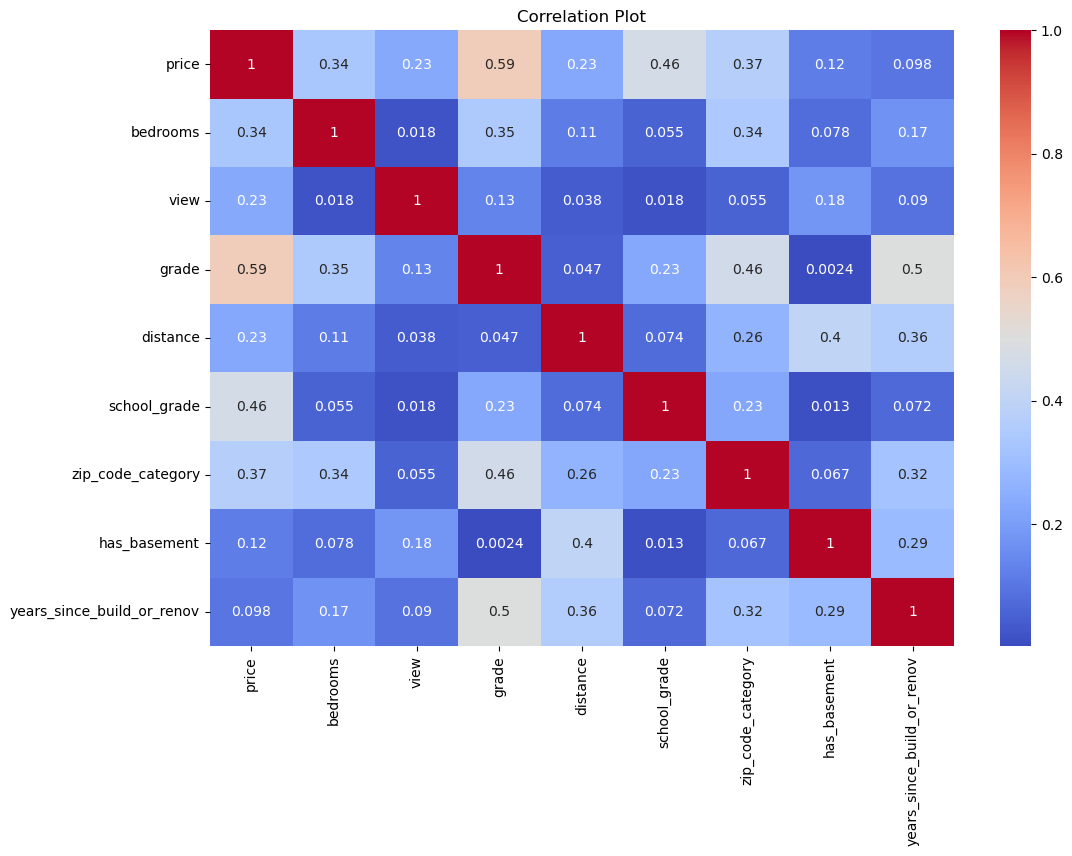

In [3289]:
# Calculate the correlation matrix
corr = abs(train_data.corr())

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Add a title to the plot
plt.title("Correlation Plot")

# Show the plot
plt.show()

In [3290]:
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     2294.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:05:59   Log-Likelihood:            -1.9644e+05
No. Observations:               14030   AIC:                         3.929e+05
Df Residuals:                   14020   BIC:                         3.930e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

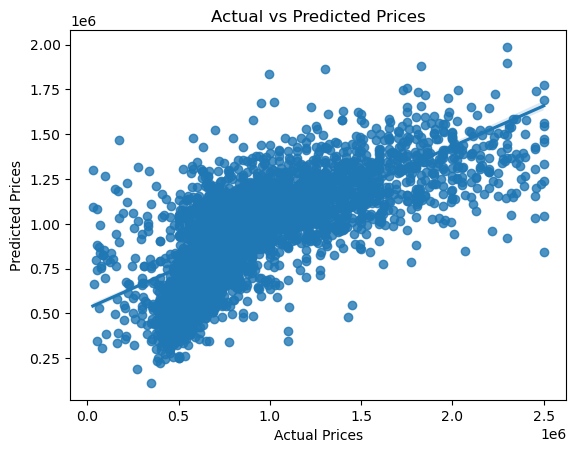

In [3291]:
# Fit the model to the training data
model = sm.OLS(train_data['price'], train_data.drop(['price'], axis=1))
results = model.fit()

# Use the fitted model to make predictions on the test data
predictions = results.predict(test_data.drop(['price'], axis=1))

# Compare the predicted values with the actual prices in the test data
sns.regplot(x=test_data['price'], y=predictions)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

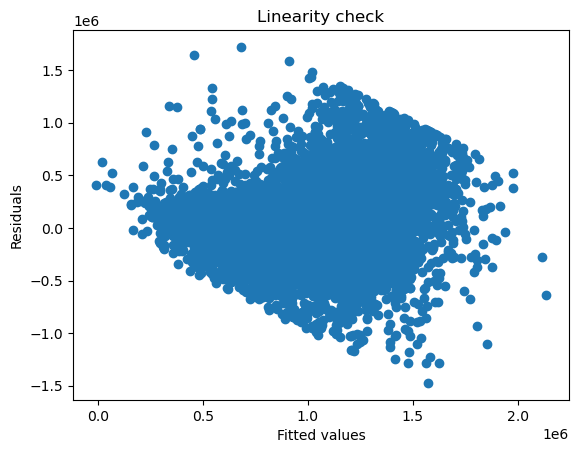

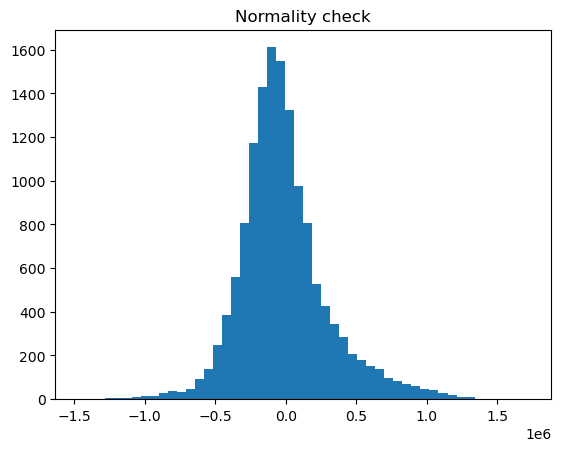

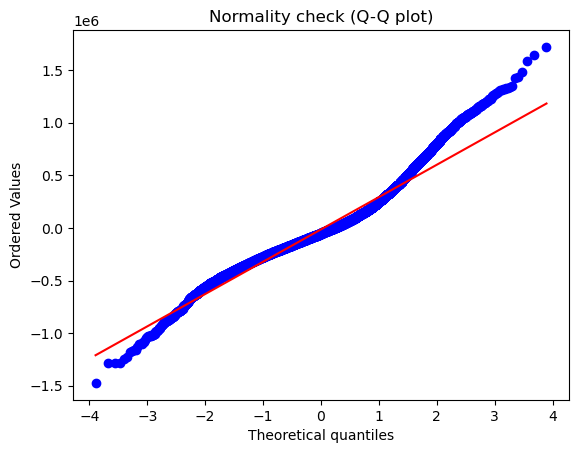

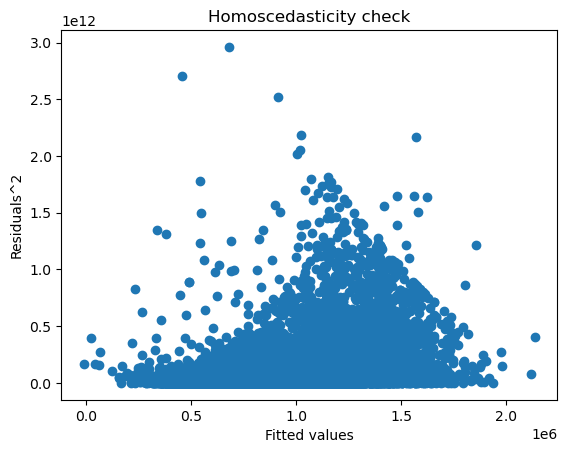

In [3292]:
# calculate the residuals
residuals = results.resid

# Plot the residuals against the fitted values to check for linearity
plt.scatter(results.fittedvalues, residuals)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Linearity check")
plt.show()

# Plot a histogram of the residuals to check for normality
plt.hist(residuals, bins=50)
plt.title("Normality check")
plt.show()

# Plot a Q-Q plot of the residuals to check for normality

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normality check (Q-Q plot)")
plt.show()

# Plot the residuals against the fitted values to check for homoscedasticity
plt.scatter(results.fittedvalues, residuals**2)
plt.xlabel("Fitted values")
plt.ylabel("Residuals^2")
plt.title("Homoscedasticity check")

plt.show()

In [3293]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test_data['price'], predictions))

# Calculate the MAE
mae = mean_absolute_error(test_data['price'], predictions)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 320906.2068311309
MAE: 234614.95828498935


In [3294]:
test_data['id'] = test_data.index
difference = pd.DataFrame({'id': test_data['id'], 'difference': test_data['price'] - predictions})
index_of_largest_difference = difference['difference'].idxmax()
print(test_data.loc[index_of_largest_difference])

price                        2500000.00
bedrooms                           4.00
waterfront                         0.00
view                               1.00
grade                              7.00
distance                           0.34
school_grade                      -0.85
zip_code_category                  2.00
has_basement                       0.00
years_since_build_or_renov         0.67
id                             23836.00
Name: 23836, dtype: float64
